In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tf_keras
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

2025-04-17 20:36:16.137934: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 20:36:16.490074: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 20:36:16.758560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744902377.051571  774173 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744902377.136568  774173 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744902377.581483  774173 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Download a dataset

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[:90%]'],
    with_info=True,
    as_supervised=True
)

2025-04-17 20:36:32.660794: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


2025-04-17 20:36:33.929489: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-04-17 20:36:35.266299: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


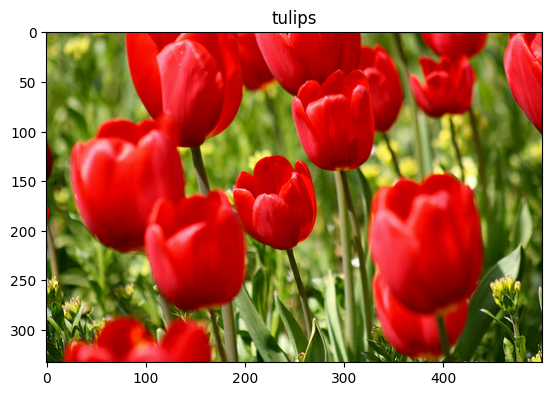

In [4]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

### Use Keras preprocessing layers

##### Resizing and rescaling

In [5]:
IMG_SIZE = 100

resize_and_rescale = tf_keras.Sequential([
    tf_keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    tf_keras.layers.Rescaling(1./255)
])

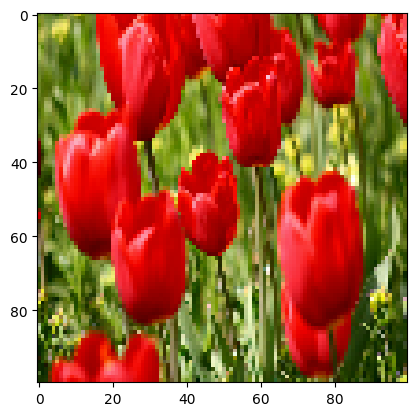

In [6]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [7]:
print("Min and max pixel values: ", result.numpy().min(), result.numpy().max())

Min and max pixel values:  0.0 1.0


##### Data augmentation

In [8]:
data_augmentation = tf_keras.Sequential([
    tf_keras.layers.RandomFlip("horizontal_and_vertical"),
    tf_keras.layers.RandomRotation(0.2)
])

In [9]:
# Add the image to a batch
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

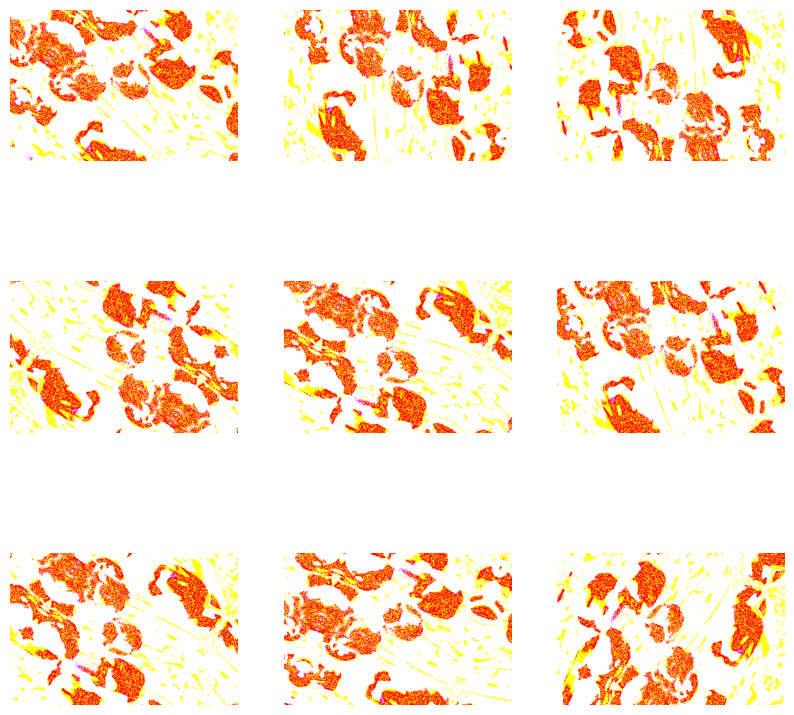

In [10]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

##### Two options to use the Keras preprocessing layers

1. Make the preprocessing layers part of your model

In [11]:
model = tf_keras.Sequential([
    # Add the preprocessing layers you created earlier.
    resize_and_rescale,
    data_augmentation,
    tf_keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf_keras.layers.MaxPooling2D(),
    # Rest of your model.
])

2. Apply the preprocessing layers to your dataset

In [12]:
aug_ds = train_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
)

### Apply the preprocessing layers to the datasets

In [13]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(
        lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE
    )
    
    if shuffle:
        ds = ds.shuffle(1000)
        
    # Batch all datasets.
    ds = ds.batch(batch_size)
    
    # Use data augmentation only on the training sets.
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE
        )
    
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
train_ds = prepare(train_ds, shuffle=True, augment=True)

In [15]:
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### Train a model

In [16]:
model = tf_keras.Sequential([
    tf_keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf_keras.layers.MaxPool2D(),
    tf_keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf_keras.layers.MaxPooling2D(),
    tf_keras.layers.Conv2D(64, 3, padding="same", activation='relu'),
    tf_keras.layers.MaxPool2D(),
    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(128, activation='relu'),
    tf_keras.layers.Dense(num_classes)
])

In [17]:
model.compile(
    optimizer='adam',
    loss=tf_keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [18]:
epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5


2025-04-17 20:36:47.168403: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23760000 exceeds 10% of free system memory.
2025-04-17 20:36:47.169022: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23760000 exceeds 10% of free system memory.
2025-04-17 20:36:47.283886: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25920000 exceeds 10% of free system memory.


 2/92 [..............................] - ETA: 17s - loss: 1.8941 - accuracy: 0.1875 

2025-04-17 20:36:47.493899: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23760000 exceeds 10% of free system memory.
2025-04-17 20:36:47.494116: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23760000 exceeds 10% of free system memory.


92/92 [==============================] - 26s 230ms/step - loss: 1.3095 - accuracy: 0.4193 - val_loss: 1.1575 - val_accuracy: 0.4959
Epoch 2/5
92/92 [==============================] - 18s 186ms/step - loss: 1.0835 - accuracy: 0.5644 - val_loss: 0.9757 - val_accuracy: 0.6458
Epoch 3/5
92/92 [==============================] - 16s 172ms/step - loss: 0.9773 - accuracy: 0.6124 - val_loss: 0.9033 - val_accuracy: 0.6512
Epoch 4/5
92/92 [==============================] - 17s 178ms/step - loss: 0.9141 - accuracy: 0.6386 - val_loss: 0.9018 - val_accuracy: 0.6703
Epoch 5/5
92/92 [==============================] - 16s 172ms/step - loss: 0.8826 - accuracy: 0.6553 - val_loss: 0.8697 - val_accuracy: 0.6567


In [19]:
loss, acc = model.evaluate(test_ds)
print("Accuracy:", acc)

104/104 [==============================] - 8s 74ms/step - loss: 0.8118 - accuracy: 0.6845
Accuracy: 0.6845292448997498


### Custom data augmentation

In [20]:
def random_invert_img(x, p=0.5):
    if tf.random.uniform([]) < p:
        x = (255 - x)
    else:
        x
    return x

In [21]:
def random_invert(factor=0.5):
    return tf_keras.layers.Lambda(
        lambda x: random_invert_img(x, factor)
    )

In [22]:
random_invert = random_invert()

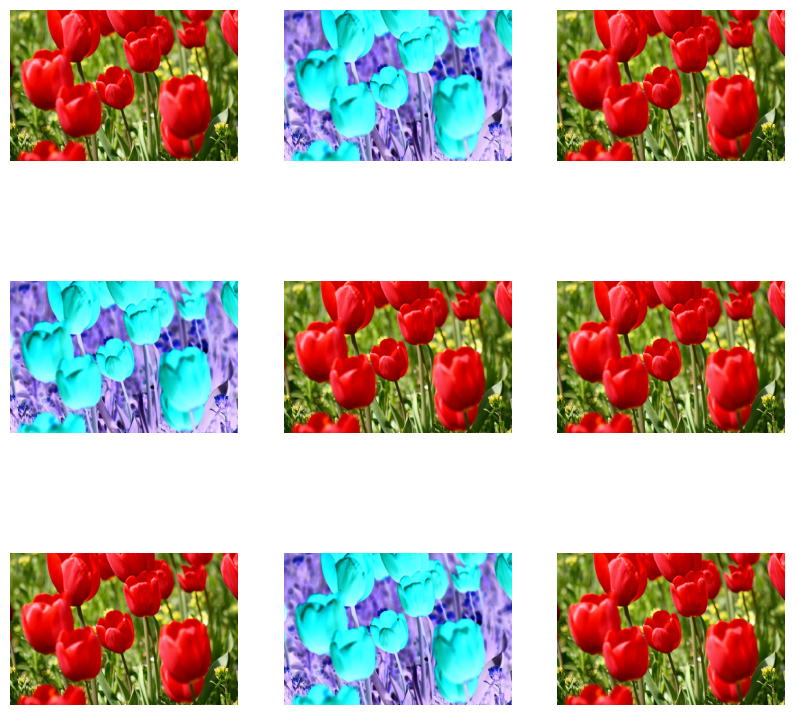

In [23]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis('off')

In [24]:
class RandomInvert(tf_keras.layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor
    
    def call(self, x):
        return random_invert_img(x)

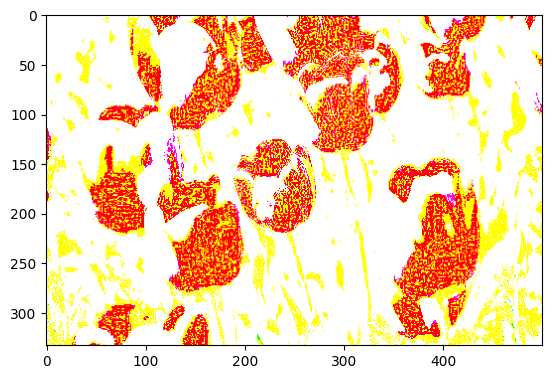

In [25]:
_ = plt.imshow(RandomInvert()(image[0]))

### Using tf.image

In [26]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    "tf_flowers",
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

2025-04-17 20:38:26.819282: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


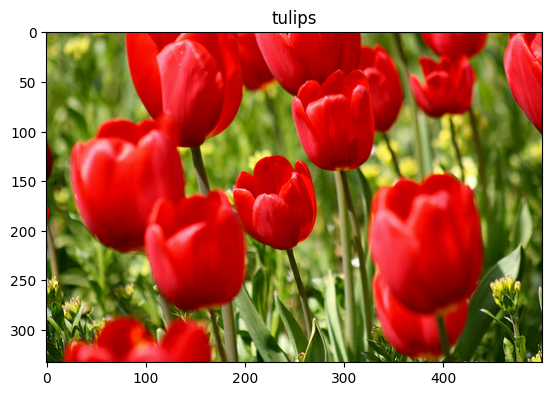

In [27]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [28]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original image")
    plt.imshow(original)
    
    plt.subplot(1, 2, 2)
    plt.title("Augmented image")
    plt.imshow(augmented)

### Data augmentation

##### Flip an image

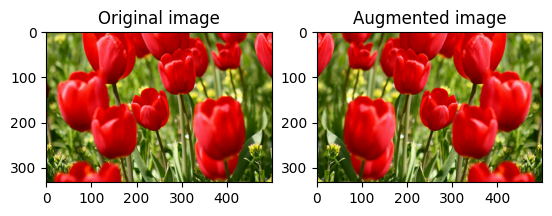

In [29]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

##### Grayscale an image

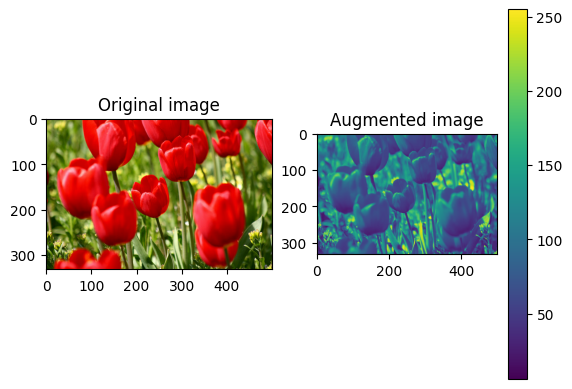

In [30]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

##### Saturate an image

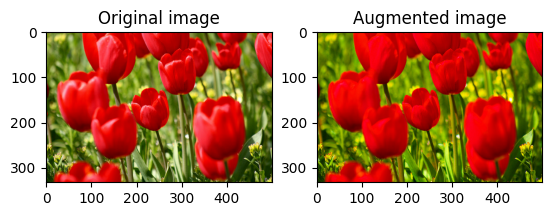

In [31]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

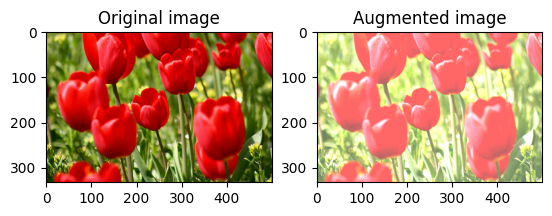

In [32]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

##### Center crop an image


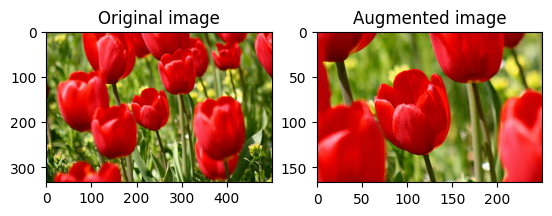

In [33]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

##### Rotate an image

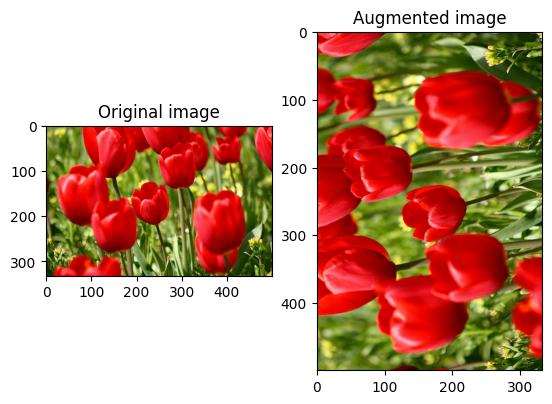

In [34]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

#### Random transformations

##### Randomly change image brightness

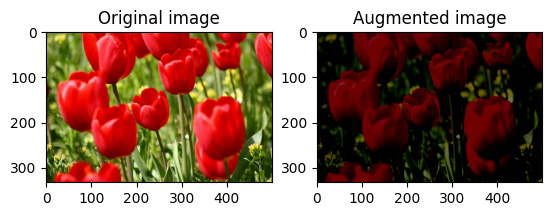

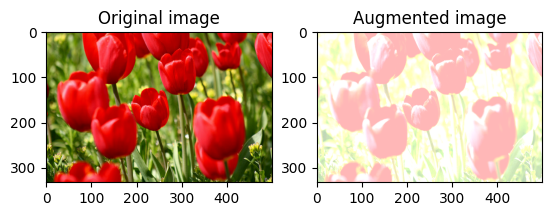

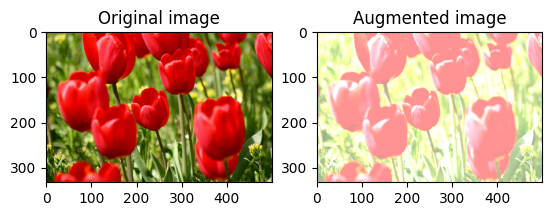

In [35]:
for i in range(3):
    seed = (i, 0)   # tuple of size (2,)
    stateless_random_brightness = tf.image.stateless_random_brightness(
        image, max_delta=0.95, seed=seed
    )
    visualize(image, stateless_random_brightness)

#### Randomly change image contract

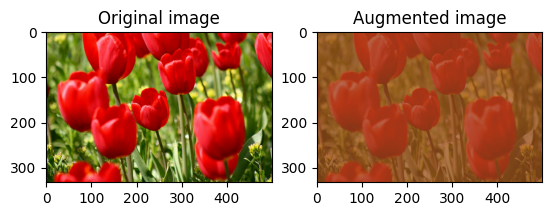

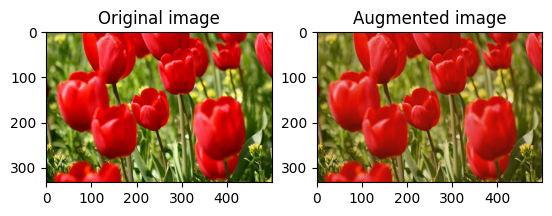

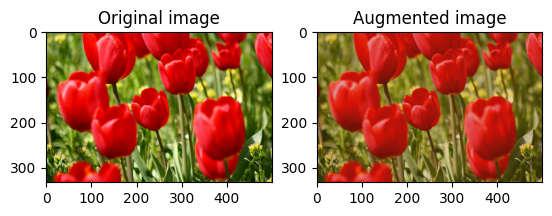

In [36]:
for i in range(3):
    seed = (i, 0)   # tuple of size (2,)
    stateless_random_contrast = tf.image.stateless_random_contrast(
        image, lower=0.1, upper=0.9, seed=seed
    )
    visualize(image, stateless_random_contrast)

#### Randomly crop an image

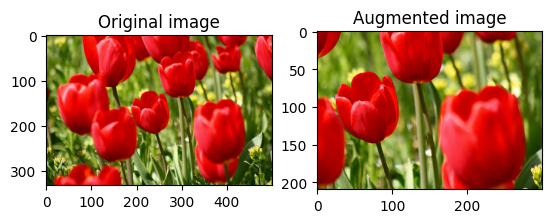

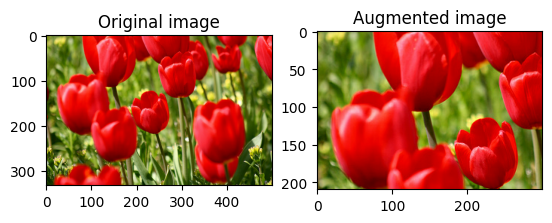

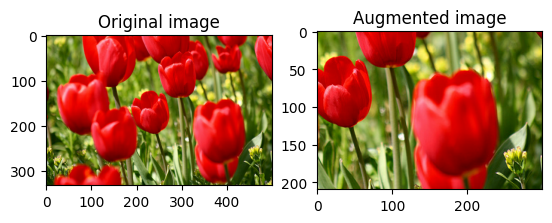

In [37]:
for i in range(3):
    seed = (i, 0)   # tuple of size (2, )
    stateless_random_crop = tf.image.stateless_random_crop(
        image, size=[210, 300, 3], seed=seed
    )
    visualize(image, stateless_random_crop)

### Apply augmentation to a dataset

In [38]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    "tf_flowers",
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

In [39]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [40]:
def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_rescale(image, label)
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
    # Make a new seed.count
    new_seed = tf.random.split(seed, num=1)[0, :]
    image = tf.image.stateless_random_crop(
        image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed
    )
    # Random brightness
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed
    )
    image = tf.clip_by_value(image, 0, 1)
    return image, label

##### Option 1: Using tf.data.experimental.Counter

In [42]:
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

In [43]:
train_ds = (
    train_ds.shuffle(1000).map(augment, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
)

In [44]:
val_ds = (
    val_ds.map(resize_and_rescale, num_parallel_calls=AUTOTUNE)\
        .batch(batch_size).prefetch(AUTOTUNE)
)

In [45]:
test_ds = (
    test_ds.map(resize_and_rescale, num_parallel_calls=AUTOTUNE)\
        .batch(batch_size).prefetch(AUTOTUNE)
)

##### Option 2: Using tf.random.Generator

In [46]:
# Create a generator
rng = tf.random.Generator.from_seed(123, alg='philox')

In [47]:
# Create a wrapper function for updating seeds.
def f(x, y):
    seed = rng.make_seeds(1)[:, 0]
    image, label = augment((x, y), seed)
    return image, label

In [ ]:
train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [49]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [50]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)